# Description

This notebook contains tools for debugging an individual `CcxtBroker` execution.

The notebook is responsible for aspects of the execution experiment run that are related to the correctness of the execution, as opposed to the analysis of the result:
- Consistency of logging
- Correctness in the submission of orders
- Consistency between trades and submitted orders
- Order time profiling

In [45]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import logging

import core.config as cconfig
import helpers.hdbg as hdbg
import helpers.henv as henv
import helpers.hprint as hprint
import im_v2.common.universe as ivcu
import oms.broker.ccxt.ccxt_aggregation_functions as obccagfu
import oms.broker.ccxt.ccxt_execution_quality as obccexqu
import oms.broker.ccxt.ccxt_logger as obcccclo

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
hdbg.init_logger(verbosity=logging.INFO)

_LOG = logging.getLogger(__name__)

_LOG.info("%s", henv.get_system_signature()[0])

hprint.config_notebook()

INFO  # Git
  branch_name='CmTask7612_full_symbol_mapping'
  hash='f805f167f'
  # Last commits:
    * f805f167f tamriq   CmTask7612: specify the universe version                          (   4 hours ago) Wed Mar 20 12:38:29 2024  (HEAD -> CmTask7612_full_symbol_mapping, origin/CmTask7612_full_symbol_mapping)
    * aeab9b2f0 Shayan   EFS volume setup added to initContainers (#7603)                  (  25 hours ago) Tue Mar 19 16:17:02 2024  (origin/master, origin/HEAD, origin/CmTask7602_total_vol_0_in_master_execution_analysis)
    * d0c46b98e Danya Tikhomirov CMTask7571: Handle price col and prediction col Nans (#7596)      (  28 hours ago) Tue Mar 19 12:37:56 2024           
# Machine info
  system=Linux
  node name=143b87d6d2e6
  release=5.15.0-1053-aws
  version=#58~20.04.1-Ubuntu SMP Mon Jan 22 17:15:01 UTC 2024
  machine=x86_64
  processor=x86_64
  cpu count=8
  cpu freq=scpufreq(current=2499.992, min=0.0, max=0.0)
  memory=svmem(total=33280278528, available=20393787392, percent=3

In [47]:
config = cconfig.get_config_from_env()
if config:
    # Get config from env when running the notebook via the `run_notebook.py` script, e.g.
    # in the system reconciliation flow.
    _LOG.info("Using config from env vars")
else:
    system_log_dir = "/shared_data/toma/CmTask7440_1"

    config_dict = {"system_log_dir": system_log_dir}
    config = cconfig.Config.from_dict(config_dict)
print(config)

system_log_dir: /shared_data/ecs/test/system_reconciliation/C11a/prod/20240312_220000.20240312_225500/system_log_dir.manual/process_forecasts


In [48]:
log_dir = config["system_log_dir"]
ccxt_log_reader = obcccclo.CcxtLogger(log_dir)
#
data = ccxt_log_reader.load_all_data(
    convert_to_dataframe=True, abort_on_missing_data=False
)
ccxt_order_response_df = data["ccxt_order_responses"]
ccxt_trades_df = data["ccxt_trades"]
oms_child_order_df = data["oms_child_orders"]
oms_parent_order_df = data["oms_parent_orders"]
ccxt_fills = data["ccxt_fills"]

WARNING Path '/shared_data/ecs/test/system_reconciliation/C11a/prod/20240312_220000.20240312_225500/system_log_dir.manual/process_forecasts/args.json' doesn't exist!
WARNING Path '/shared_data/ecs/test/system_reconciliation/C11a/prod/20240312_220000.20240312_225500/system_log_dir.manual/process_forecasts/balances' doesn't exist!
WARNING Path '/shared_data/ecs/test/system_reconciliation/C11a/prod/20240312_220000.20240312_225500/system_log_dir.manual/process_forecasts/reduce_only/ccxt_child_order_responses' doesn't exist!
WARNING Path '/shared_data/ecs/test/system_reconciliation/C11a/prod/20240312_220000.20240312_225500/system_log_dir.manual/process_forecasts/reduce_only/oms_child_orders' doesn't exist!
WARNING Missing required data for 'args': continuing as per user request


Loading '/shared_data/ecs/test/system_reconciliation/C11a/prod/20240312_220000.20240312_225500/system_log_dir.…

Loading '/shared_data/ecs/test/system_reconciliation/C11a/prod/20240312_220000.20240312_225500/system_log_dir.…

Loading '/shared_data/ecs/test/system_reconciliation/C11a/prod/20240312_220000.20240312_225500/system_log_dir.…

Loading '/shared_data/ecs/test/system_reconciliation/C11a/prod/20240312_220000.20240312_225500/system_log_dir.…

Loading '/shared_data/ecs/test/system_reconciliation/C11a/prod/20240312_220000.20240312_225500/system_log_dir.…

Loading '/shared_data/ecs/test/system_reconciliation/C11a/prod/20240312_220000.20240312_225500/system_log_dir.…

Loading '/shared_data/ecs/test/system_reconciliation/C11a/prod/20240312_220000.20240312_225500/system_log_dir.…

Loading '/shared_data/ecs/test/system_reconciliation/C11a/prod/20240312_220000.20240312_225500/system_log_dir.…

Loading '/shared_data/ecs/test/system_reconciliation/C11a/prod/20240312_220000.20240312_225500/system_log_dir.…

WARNING Missing required data for 'balances': continuing as per user request
WARNING Missing required data for 'reduce_only_order_responses': continuing as per user request


In [49]:
# Print the Broker config.
if "broker_config" in data:
    print(hprint.to_pretty_str(data["broker_config"]))
    universe_version = data["broker_config"]["universe_version"]
else:
    _LOG.warning("broker_config file not present in %s", log_dir)
    universe_version = None

{'bid_ask_lookback': '60S',
 'child_order_quantity_computer': {'object_type': 'DynamicSchedulingChildOrderQuantityComputer'},
 'limit_price_computer': {'_volatility_multiple': [1.5,
                                                   0.7,
                                                   0.7,
                                                   0.6,
                                                   0.6,
                                                   0.5,
                                                   10.0,
                                                   10.0,
                                                   10.0,
                                                   10.0,
                                                   10.0,
                                                   10.0,
                                                   10.0,
                                                   10.0,
                                                   10.0,
                         

In [50]:
# Print the used Config, if any.
experiment_config = obcccclo.load_config_for_execution_analysis(log_dir)
print(experiment_config)

INFO  Loading config from /shared_data/ecs/test/system_reconciliation/C11a/prod/20240312_220000.20240312_225500/system_log_dir.manual/system_config.output.values_as_strings.pkl
dag_config: ('False', 'None', "generate_feature_panels: 
  in_col_groups: [('close',), ('high',), ('low',), ('open',), ('volume',)]
  out_col_group: ()
  transformer_kwargs: 
    bar_normalization_method: volume
resample: 
  in_col_groups: [('open',), ('high',), ('low',), ('close',), ('volume',), ('p1',), ('p2',), ('p3',), ('p_lr',), ('p_est',), ('p_diff',), ('q1',), ('q2',), ('q3',), ('q4',), ('q5',), ('q6',), ('q_mv',), ('q_mv_adj',), ('q_mv_os',), ('r1',), ('r2',), ('r3',), ('r4',), ('r5',), ('r6',), ('r_lr',), ('r_est',), ('v_ld',)]
  out_col_group: ()
  transformer_kwargs: 
    rule: 4T
    volume_weight: volume
  reindex_like_input: False
  join_output_with_input: False
compute_vol: 
  in_col_groups: [('close',), ('high',), ('low',), ('open',)]
  out_col_group: ()
  transformer_kwargs: 
    estimators: ['c

In [51]:
ccxt_order_response_df.head(3)

,info,order,client_order_id,timestamp,datetime,last_trade_timestamp,lastUpdateTimestamp,symbol,order_type,time_in_force,post_only,reduce_only,side,order_price,triggerPrice,order_amount,cost,average,filled,remaining,status,fee,trades,fees,stop_price,takeProfitPrice,stopLossPrice,order_update_timestamp,order_update_datetime
0,"{'orderId': '8389765661335852855', 'symbol': '...",8389765661335852855,x-xcKtGhcu604bf781752efae5e00cab,1710281527362,2024-03-12T22:12:07.362Z,NaN,1710281527362,ETH/USDT:USDT,limit,GTC,False,False,sell,3951.41,None,0.114,0.0,NaN,0.0,0.114,open,None,[],[],None,None,None,1710281527362,2024-03-12 22:12:07.362000+00:00
1,"{'orderId': '8389765661335866682', 'symbol': '...",8389765661335866682,x-xcKtGhcu2704146e9969f24e763eb9,1710281531430,2024-03-12T22:12:11.430Z,NaN,1710281531430,ETH/USDT:USDT,limit,GTC,False,False,sell,3950.96,None,0.114,0.0,NaN,0.0,0.114,open,None,[],[],None,None,None,1710281531430,2024-03-12 22:12:11.430000+00:00
2,"{'orderId': '8389765661336663272', 'symbol': '...",8389765661336663272,x-xcKtGhcu6d9540937aaa38927bf898,1710281766135,2024-03-12T22:16:06.135Z,NaN,1710281766135,ETH/USDT:USDT,limit,GTC,False,False,sell,3957.85,None,0.038,0.0,NaN,0.0,0.038,open,None,[],[],None,None,None,1710281766135,2024-03-12 22:16:06.135000+00:00


## Child order responses

In [52]:
ccxt_order_response_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   info                    134 non-null    object             
 1   order                   134 non-null    int64              
 2   client_order_id         134 non-null    object             
 3   timestamp               134 non-null    int64              
 4   datetime                134 non-null    object             
 5   last_trade_timestamp    4 non-null      float64            
 6   lastUpdateTimestamp     134 non-null    int64              
 7   symbol                  134 non-null    object             
 8   order_type              134 non-null    object             
 9   time_in_force           134 non-null    object             
 10  post_only               134 non-null    bool               
 11  reduce_only             134 non-null    bool 

## Child orders

In [53]:
oms_child_order_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 193 entries, 3 to 211
Data columns (total 35 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   creation_timestamp         193 non-null    datetime64[ns, UTC]
 1   asset_id                   193 non-null    int64              
 2   type_                      193 non-null    object             
 3   start_timestamp            193 non-null    datetime64[ns, UTC]
 4   end_timestamp              193 non-null    datetime64[ns, UTC]
 5   curr_num_shares            193 non-null    float64            
 6   diff_num_shares            193 non-null    float64            
 7   tz                         193 non-null    object             
 8   extra_params               193 non-null    object             
 9   volatility_multiple        193 non-null    float64            
 10  wave_id                    193 non-null    int64              
 11  num_data_po

In [54]:
oms_child_order_df.head(3)

,creation_timestamp,asset_id,type_,start_timestamp,end_timestamp,curr_num_shares,diff_num_shares,tz,extra_params,volatility_multiple,wave_id,num_data_points,exchange_timestamp,knowledge_timestamp,end_download_timestamp,latest_bid_size,latest_ask_size,num_data_points_resampled,scaling_multiplier,bid_vol,bid_vol_bps,latest_bid_price,ask_vol,ask_vol_bps,latest_ask_price,total_vol,latest_mid_price,total_vol_bps,spread,spread_bps,total_vol_to_spread_bps,limit_price,ccxt_id,name,attempt_num
order_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3,2024-03-12 22:12:06.669720+00:00,1464553467,limit,2024-03-12 22:12:06.669720+00:00,2024-03-12 22:12:10+00:00,0.000,-0.114,America/New_York,{'stats': {'_submit_twap_child_order::wave_id'...,1.5,0,277,2024-03-12 22:12:04.914000+00:00,2024-03-12 22:12:05.031638+00:00,2024-03-12 22:12:05.022958+00:00,26.178,18.977,598,10.0,0.514399,1.302065,3950.64,0.514594,1.302556,3950.65,0.514497,3950.645,1.302311,0.01,0.025312,51.449671,3951.41,8389765661335852855,3,1
5,2024-03-12 22:12:11.409968+00:00,1464553467,limit,2024-03-12 22:12:11.409968+00:00,2024-03-12 22:12:20+00:00,0.000,-0.114,America/New_York,{'stats': {'_submit_twap_child_order::wave_id'...,0.7,1,279,2024-03-12 22:12:09.710000+00:00,2024-03-12 22:12:09.770832+00:00,2024-03-12 22:12:09.762096+00:00,13.329,33.149,598,10.0,0.462243,1.170045,3950.64,0.462460,1.170592,3950.65,0.462351,3950.645,1.170319,0.01,0.025312,46.235143,3950.96,8389765661335866682,5,1
9,2024-03-12 22:16:06.115404+00:00,1464553467,limit,2024-03-12 22:16:06.115404+00:00,2024-03-12 22:16:10+00:00,-0.114,-0.038,America/New_York,{'stats': {'_submit_twap_child_order::wave_id'...,1.5,0,291,2024-03-12 22:16:04.532000+00:00,2024-03-12 22:16:04.565772+00:00,2024-03-12 22:16:04.557261+00:00,25.772,49.754,597,10.0,0.565700,1.429619,3957.00,0.565700,1.429615,3957.01,0.565700,3957.005,1.429617,0.01,0.025272,56.570026,3957.85,8389765661336663272,9,1


### Extract the OMS parent order ID

In [55]:
oms_child_order_df["parent_order_id"] = oms_child_order_df["extra_params"].apply(
    lambda x: x["oms_parent_order_id"]
)
oms_child_order_df.head(3)

,creation_timestamp,asset_id,type_,start_timestamp,end_timestamp,curr_num_shares,diff_num_shares,tz,extra_params,volatility_multiple,wave_id,num_data_points,exchange_timestamp,knowledge_timestamp,end_download_timestamp,latest_bid_size,latest_ask_size,num_data_points_resampled,scaling_multiplier,bid_vol,bid_vol_bps,latest_bid_price,ask_vol,ask_vol_bps,latest_ask_price,total_vol,latest_mid_price,total_vol_bps,spread,spread_bps,total_vol_to_spread_bps,limit_price,ccxt_id,name,attempt_num,parent_order_id
order_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3,2024-03-12 22:12:06.669720+00:00,1464553467,limit,2024-03-12 22:12:06.669720+00:00,2024-03-12 22:12:10+00:00,0.000,-0.114,America/New_York,{'stats': {'_submit_twap_child_order::wave_id'...,1.5,0,277,2024-03-12 22:12:04.914000+00:00,2024-03-12 22:12:05.031638+00:00,2024-03-12 22:12:05.022958+00:00,26.178,18.977,598,10.0,0.514399,1.302065,3950.64,0.514594,1.302556,3950.65,0.514497,3950.645,1.302311,0.01,0.025312,51.449671,3951.41,8389765661335852855,3,1,1
5,2024-03-12 22:12:11.409968+00:00,1464553467,limit,2024-03-12 22:12:11.409968+00:00,2024-03-12 22:12:20+00:00,0.000,-0.114,America/New_York,{'stats': {'_submit_twap_child_order::wave_id'...,0.7,1,279,2024-03-12 22:12:09.710000+00:00,2024-03-12 22:12:09.770832+00:00,2024-03-12 22:12:09.762096+00:00,13.329,33.149,598,10.0,0.462243,1.170045,3950.64,0.462460,1.170592,3950.65,0.462351,3950.645,1.170319,0.01,0.025312,46.235143,3950.96,8389765661335866682,5,1,1
9,2024-03-12 22:16:06.115404+00:00,1464553467,limit,2024-03-12 22:16:06.115404+00:00,2024-03-12 22:16:10+00:00,-0.114,-0.038,America/New_York,{'stats': {'_submit_twap_child_order::wave_id'...,1.5,0,291,2024-03-12 22:16:04.532000+00:00,2024-03-12 22:16:04.565772+00:00,2024-03-12 22:16:04.557261+00:00,25.772,49.754,597,10.0,0.565700,1.429619,3957.00,0.565700,1.429615,3957.01,0.565700,3957.005,1.429617,0.01,0.025272,56.570026,3957.85,8389765661336663272,9,1,7


In [56]:
# Check how many child orders are generated per parent_order_id.
oms_child_order_df["parent_order_id"].value_counts().value_counts()

count
2     9
24    7
1     2
5     1
Name: count, dtype: int64

### Check the error messages in non-submitted orders.

In [57]:
# Select the OMS child orders with no CCXT ID and check their error messages.
not_submitted_oms_child_order_df = oms_child_order_df.loc[
    oms_child_order_df["ccxt_id"] == -1
]
print(
    f"Number of not submitted OMS child orders={not_submitted_oms_child_order_df.shape[0]} \
    out of total orders={oms_child_order_df.shape[0]}"
)

Number of not submitted OMS child orders=59     out of total orders=193


In [58]:
# Extract all error messages from unsubmitted orders.
not_submitted_oms_child_order_df["error_msg"] = not_submitted_oms_child_order_df[
    "extra_params"
].apply(lambda x: x["error_msg"])

In [59]:
# Display error messages grouped by symbol.
# Get the universe to map asset_id's.
universe = ivcu.get_vendor_universe(
    "CCXT", "trade", version=universe_version, as_full_symbol=True
)
asset_id_to_symbol_mapping = ivcu.build_numerical_to_string_id_mapping(universe)
not_submitted_oms_child_order_df[
    "full_symbol"
] = not_submitted_oms_child_order_df["asset_id"].map(asset_id_to_symbol_mapping)
# Get value counts of error messages.
error_msg = not_submitted_oms_child_order_df.groupby("full_symbol")[
    "error_msg"
].value_counts()
error_msg

full_symbol        error_msg                                                                                                  
binance::ETH_USDT  binance {"code":-4164,"msg":"Order's notional must be no smaller than 20 (unless you choose reduce only)."}    59
Name: count, dtype: int64

### Check the buy and sell orders with max notional

In [60]:
oms_child_order_notionals = (
    oms_child_order_df["diff_num_shares"] * oms_child_order_df["limit_price"]
)
max_sell_notional = oms_child_order_notionals[oms_child_order_notionals < 0].min()
max_buy_notional = oms_child_order_notionals[oms_child_order_notionals > 0].max()
_LOG.info(
    "Max sell notional: %s\nMax buy notional: %s",
    max_sell_notional,
    max_buy_notional,
)

INFO  Max sell notional: -1135.3424
Max buy notional: 1136.6976000000002


## Parent orders

In [61]:
oms_parent_order_df.head(3)

,creation_timestamp,asset_id,type_,start_timestamp,end_timestamp,curr_num_shares,diff_num_shares,tz,extra_params
order_id,,,,,,,,,
0,2024-03-12 22:12:04.902710+00:00,1467591036,price@twap,2024-03-12 22:12:04.902710+00:00,2024-03-12 22:16:00+00:00,0.000,-0.008,America/New_York,"{'ccxt_symbol': 'BTC/USDT:USDT', 'stats': {'_s..."
1,2024-03-12 22:12:04.902710+00:00,1464553467,price@twap,2024-03-12 22:12:04.902710+00:00,2024-03-12 22:16:00+00:00,0.000,-0.114,America/New_York,"{'ccxt_symbol': 'ETH/USDT:USDT', 'stats': {'_s..."
6,2024-03-12 22:16:04.675241+00:00,1467591036,price@twap,2024-03-12 22:16:04.675241+00:00,2024-03-12 22:20:00+00:00,-0.008,0.002,America/New_York,"{'ccxt_symbol': 'BTC/USDT:USDT', 'stats': {'_s..."


In [62]:
# Extract `ccxt_id` of child orders into a separate column.
oms_parent_order_df["child_order_ccxt_ids"] = oms_parent_order_df[
    "extra_params"
].apply(lambda x: x["ccxt_id"])
oms_parent_order_df.head(3)

,creation_timestamp,asset_id,type_,start_timestamp,end_timestamp,curr_num_shares,diff_num_shares,tz,extra_params,child_order_ccxt_ids
order_id,,,,,,,,,,
0,2024-03-12 22:12:04.902710+00:00,1467591036,price@twap,2024-03-12 22:12:04.902710+00:00,2024-03-12 22:16:00+00:00,0.000,-0.008,America/New_York,"{'ccxt_symbol': 'BTC/USDT:USDT', 'stats': {'_s...","[285037837513, 285037883295]"
1,2024-03-12 22:12:04.902710+00:00,1464553467,price@twap,2024-03-12 22:12:04.902710+00:00,2024-03-12 22:16:00+00:00,0.000,-0.114,America/New_York,"{'ccxt_symbol': 'ETH/USDT:USDT', 'stats': {'_s...","[8389765661335852855, 8389765661335866682]"
6,2024-03-12 22:16:04.675241+00:00,1467591036,price@twap,2024-03-12 22:16:04.675241+00:00,2024-03-12 22:20:00+00:00,-0.008,0.002,America/New_York,"{'ccxt_symbol': 'BTC/USDT:USDT', 'stats': {'_s...","[285040171765, 285040198978]"


In [63]:
# Check how many child orders per parent order were successfully submitted.
# A value between maximum expected and 0 can mean that some child orders
# could not get through, while otherwise being well-formed.
# A value of 0 means that the parent order had an issue, e.g.
# having a notional that made all child orders below a minimum.
oms_parent_order_df["submitted_child_order_num"] = oms_parent_order_df[
    "child_order_ccxt_ids"
].str.len()
oms_parent_order_df["submitted_child_order_num"].value_counts()

submitted_child_order_num
2     10
24     4
5      2
1      2
6      1
Name: count, dtype: int64

## Trades

In [64]:
ccxt_trades_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 18 entries, 2024-03-12 22:12:16.251000+00:00 to 2024-03-12 22:52:11.408000+00:00
Data columns (total 30 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   timestamp         18 non-null     datetime64[ns, UTC]
 1   datetime          18 non-null     datetime64[ns, UTC]
 2   symbol            18 non-null     object             
 3   asset_id          18 non-null     int64              
 4   id                18 non-null     int64              
 5   order             18 non-null     int64              
 6   side              18 non-null     object             
 7   takerOrMaker      18 non-null     object             
 8   price             18 non-null     float64            
 9   amount            18 non-null     float64            
 10  cost              18 non-null     float64            
 11  transaction_cost  18 non-null     float64            
 12  fe

### Verify that all trades correspond to logged child orders

In [65]:
# Verify that all trades have an associated order response.
# If the trade does not have an associated order, it means
# that a trade was executed that was not accounted for during the experiment.
all(ccxt_trades_df["order"].isin(ccxt_order_response_df["order"]))

True

In [66]:
# Verify that all trades have an associated 'ccxt_id' in OMS child orders.
# This verifies that there is a consistency between a CCXT order, OMS order and
# a CCXT trade. If a trade has no associated OMS child order `ccxt_id`, it means
# that an unexpected trade was executed, for example, by a different actor on the same account.
all(ccxt_trades_df["order"].isin(oms_child_order_df["ccxt_id"]))

True

### Check orders that do not correspond to any trades

In [67]:
# Existence of such orders is not necessarily a bug.
# It means that a given OMS child order was not filled.
child_orders_with_no_trades = ~oms_child_order_df["ccxt_id"].isin(
    ccxt_trades_df["order"]
)
child_orders_with_no_trades.sum()

179

### Check the correctness of trade amount

In [68]:
# If the traded amount is larger than the order, it means that an extra trade
# is executed and the order is filled for a larger amount.
# This can mean an accounting error on the exchange side.
trade_amount_by_order = ccxt_trades_df.groupby("order").agg({"amount": "sum"})
accepted_child_order_df = oms_child_order_df.loc[
    oms_child_order_df["ccxt_id"] != -1
]
trade_amount_by_order["child_order_amount"] = accepted_child_order_df.set_index(
    "ccxt_id"
)["diff_num_shares"].abs()

In [69]:
mask = (
    trade_amount_by_order["amount"] > trade_amount_by_order["child_order_amount"]
)
trade_amount_by_order.loc[mask]

,amount,child_order_amount
order,,
8389765661340138366,0.037,0.037


In [70]:
# Check the difference between the filled amount and the agg child order quantities.
trade_amount_by_order["diff"] = (
    trade_amount_by_order["child_order_amount"] - trade_amount_by_order["amount"]
)
trade_amount_by_order = trade_amount_by_order.rename(
    {"amount": "aggregated_trades_quantity"}, axis=1
)
trade_amount_by_order = trade_amount_by_order[
    ["child_order_amount", "aggregated_trades_quantity", "diff"]
]
trade_amount_by_order[trade_amount_by_order["diff"] > 0]

,child_order_amount,aggregated_trades_quantity,diff
order,,,


### Verify that CCXT IDs are equal in both child orders and responses

In [71]:
# Verify that we are not logging any CCXT orders that are not a part
# of the experiment, i.e. have no OMS order associated with it.
# We expect all retrieved responses to be a subset of CCXT IDs
# connected to the OMS child orders.
submitted_oms_orders_ccxt_ids = set(
    oms_child_order_df.loc[oms_child_order_df["ccxt_id"] != -1][
        "ccxt_id"
    ].unique()
)
ccxt_response_ids = set(ccxt_order_response_df["order"].unique())
ccxt_response_ids.issubset(submitted_oms_orders_ccxt_ids)

True

# Group trades by order

In [72]:
# Aggregate fills by order.
ccxt_trades_by_order = obccagfu.aggregate_fills_by_order(ccxt_trades_df)
ccxt_trades_by_order.head(3)

,first_timestamp,last_timestamp,first_datetime,last_datetime,symbol,asset_id,buy_count,sell_count,taker_count,maker_count,buy_volume,sell_volume,taker_volume,maker_volume,buy_notional,sell_notional,taker_notional,maker_notional,price,amount,cost,transaction_cost,realized_pnl
order,,,,,,,,,,,,,,,,,,,,,,,
285037883295,2024-03-12 22:12:16.251000+00:00,2024-03-12 22:12:16.251000+00:00,2024-03-12 22:12:16.251000+00:00,2024-03-12 22:12:16.251000+00:00,BTC/USDT:USDT,1467591036,0,1,0,1,0.000,0.008,0.0,0.008,0.000,568.512,0.0,568.512,71064.0,0.008,568.512,0.113702,0.000
285040198978,2024-03-12 22:16:16.770000+00:00,2024-03-12 22:16:16.770000+00:00,2024-03-12 22:16:16.770000+00:00,2024-03-12 22:16:16.770000+00:00,BTC/USDT:USDT,1467591036,1,0,0,1,0.002,0.000,0.0,0.002,142.234,0.000,0.0,142.234,71117.0,0.002,142.234,0.028447,-0.106
285042493674,2024-03-12 22:20:07.014000+00:00,2024-03-12 22:20:07.014000+00:00,2024-03-12 22:20:07.014000+00:00,2024-03-12 22:20:07.014000+00:00,BTC/USDT:USDT,1467591036,0,1,0,1,0.000,0.002,0.0,0.002,0.000,142.354,0.0,142.354,71177.0,0.002,142.354,0.028471,0.000


# Time profiling for child orders

In [73]:
oms_child_order_df_unpacked = ccxt_log_reader.load_oms_child_order(
    unpack_extra_params=True, convert_to_dataframe=True
)

Loading '/shared_data/ecs/test/system_reconciliation/C11a/prod/20240312_220000.20240312_225500/system_log_dir.…

In [74]:
# Get the timestamps of events for each child order
events = obccexqu.get_oms_child_order_timestamps(oms_child_order_df_unpacked)
events = events.sort_values(events.first_valid_index(), axis=1)

In [75]:
events.head(3)

,exchange_timestamp,end_download_timestamp,knowledge_timestamp,stats__submit_twap_child_order::get_open_positions.done,stats__submit_twap_child_order::bid_ask_market_data.start,stats__submit_twap_child_order::bid_ask_market_data.done,stats__submit_twap_child_order::child_order.created,stats__submit_twap_child_order::child_order.limit_price_calculated,stats__submit_single_order_to_ccxt::start.timestamp,stats__submit_single_order_to_ccxt::all_attempts_end.timestamp,stats__submit_twap_child_order::child_order.submitted
order_id,,,,,,,,,,,
3,2024-03-12 22:12:04.914000+00:00,2024-03-12 22:12:05.022958+00:00,2024-03-12 22:12:05.031638+00:00,2024-03-12 22:12:05.140394+00:00,2024-03-12 22:12:05.141546+00:00,2024-03-12 22:12:06.647669+00:00,2024-03-12 22:12:06.672258+00:00,2024-03-12 22:12:06.678697+00:00,2024-03-12 22:12:06.680099+00:00,2024-03-12 22:12:07.367036+00:00,2024-03-12 22:12:07.367670+00:00
5,2024-03-12 22:12:09.710000+00:00,2024-03-12 22:12:09.762096+00:00,2024-03-12 22:12:09.770832+00:00,2024-03-12 22:12:09.970314+00:00,2024-03-12 22:12:09.971574+00:00,2024-03-12 22:12:11.387294+00:00,2024-03-12 22:12:11.412629+00:00,2024-03-12 22:12:11.419067+00:00,2024-03-12 22:12:11.420533+00:00,2024-03-12 22:12:11.473233+00:00,2024-03-12 22:12:11.473792+00:00
9,2024-03-12 22:16:04.532000+00:00,2024-03-12 22:16:04.557261+00:00,2024-03-12 22:16:04.565772+00:00,2024-03-12 22:16:04.699791+00:00,2024-03-12 22:16:04.700759+00:00,2024-03-12 22:16:06.093601+00:00,2024-03-12 22:16:06.117819+00:00,2024-03-12 22:16:06.124378+00:00,2024-03-12 22:16:06.125788+00:00,2024-03-12 22:16:06.177668+00:00,2024-03-12 22:16:06.178262+00:00


In [76]:
# Get the difference between event timestamps.
time_delays = obccexqu.get_time_delay_between_events(events)

<Axes: ylabel='Time delay'>

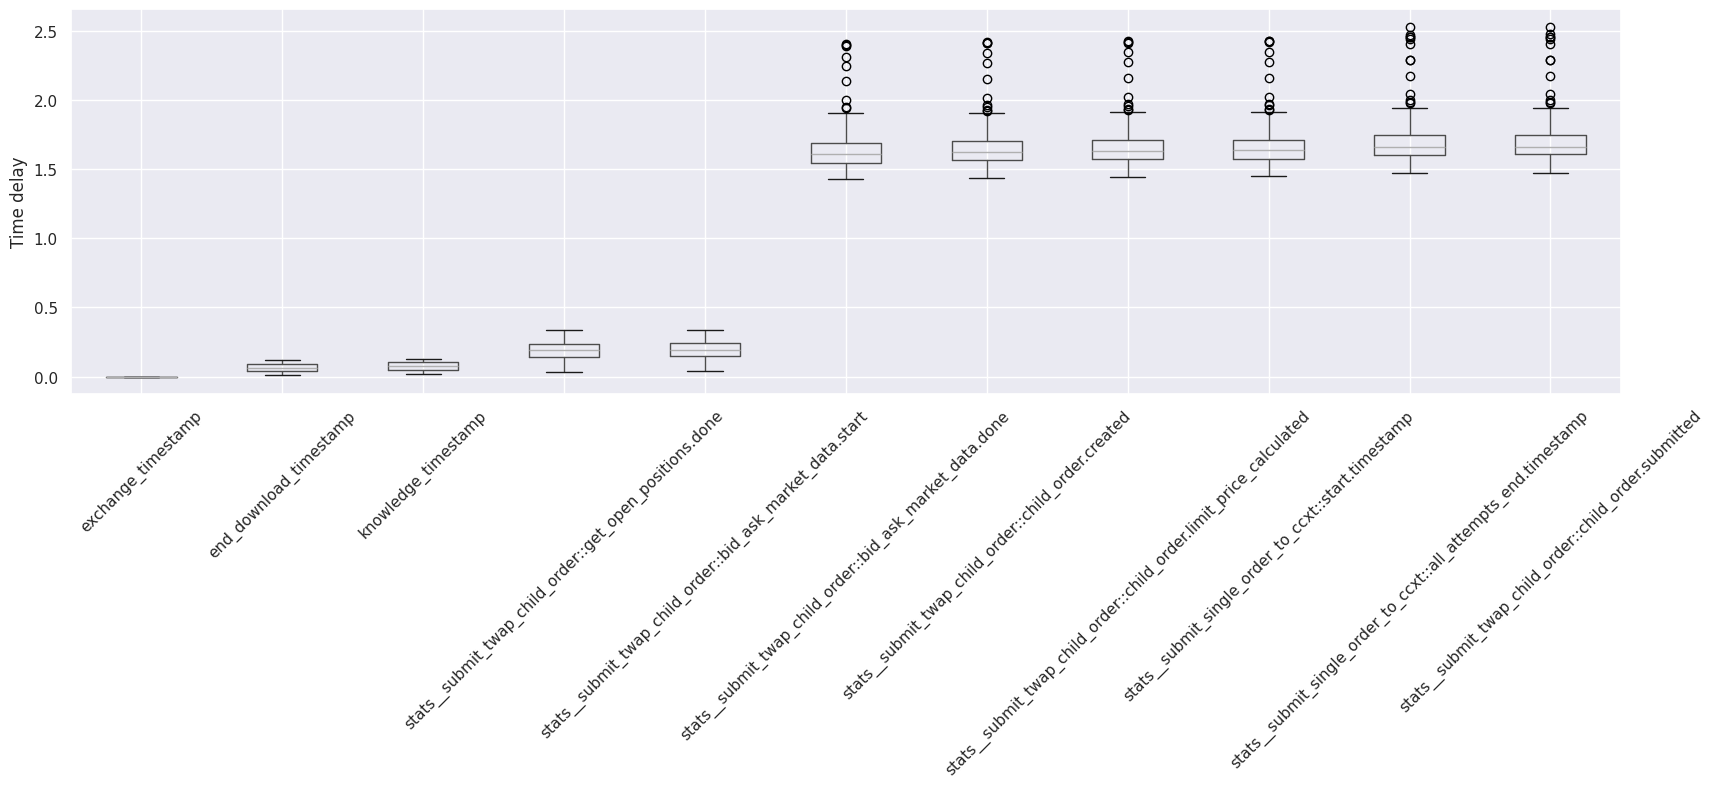

In [77]:
time_delays.boxplot(rot=45, ylabel="Time delay")

## Plot zero and non-zero waves separately

### Plot zero wave

In [78]:
# Since wave 0 begins execution later due to portfolio computation,
# we plot the time delays for it separately.
wave_zero = oms_child_order_df_unpacked[
    oms_child_order_df_unpacked["wave_id"] == 0
]
# Get the timestamps of events for each child order
wave_zero_events = obccexqu.get_oms_child_order_timestamps(wave_zero)
wave_zero_events = wave_zero_events.sort_values(
    wave_zero_events.first_valid_index(), axis=1
)

In [79]:
wave_zero_events.head(3)

,exchange_timestamp,end_download_timestamp,knowledge_timestamp,stats__submit_twap_child_order::get_open_positions.done,stats__submit_twap_child_order::bid_ask_market_data.start,stats__submit_twap_child_order::bid_ask_market_data.done,stats__submit_twap_child_order::child_order.created,stats__submit_twap_child_order::child_order.limit_price_calculated,stats__submit_single_order_to_ccxt::start.timestamp,stats__submit_single_order_to_ccxt::all_attempts_end.timestamp,stats__submit_twap_child_order::child_order.submitted
order_id,,,,,,,,,,,
3,2024-03-12 22:12:04.914000+00:00,2024-03-12 22:12:05.022958+00:00,2024-03-12 22:12:05.031638+00:00,2024-03-12 22:12:05.140394+00:00,2024-03-12 22:12:05.141546+00:00,2024-03-12 22:12:06.647669+00:00,2024-03-12 22:12:06.672258+00:00,2024-03-12 22:12:06.678697+00:00,2024-03-12 22:12:06.680099+00:00,2024-03-12 22:12:07.367036+00:00,2024-03-12 22:12:07.367670+00:00
9,2024-03-12 22:16:04.532000+00:00,2024-03-12 22:16:04.557261+00:00,2024-03-12 22:16:04.565772+00:00,2024-03-12 22:16:04.699791+00:00,2024-03-12 22:16:04.700759+00:00,2024-03-12 22:16:06.093601+00:00,2024-03-12 22:16:06.117819+00:00,2024-03-12 22:16:06.124378+00:00,2024-03-12 22:16:06.125788+00:00,2024-03-12 22:16:06.177668+00:00,2024-03-12 22:16:06.178262+00:00
37,2024-03-12 22:20:04.632000+00:00,2024-03-12 22:20:04.745524+00:00,2024-03-12 22:20:04.754177+00:00,2024-03-12 22:20:04.790823+00:00,2024-03-12 22:20:04.791887+00:00,2024-03-12 22:20:06.169846+00:00,2024-03-12 22:20:06.194339+00:00,2024-03-12 22:20:06.200779+00:00,2024-03-12 22:20:06.202143+00:00,2024-03-12 22:20:06.255982+00:00,2024-03-12 22:20:06.256546+00:00


In [80]:
# Get the difference between event timestamps.
time_delays = obccexqu.get_time_delay_between_events(wave_zero_events)

Text(0.5, 1.0, 'Time delay between events for wave 0')

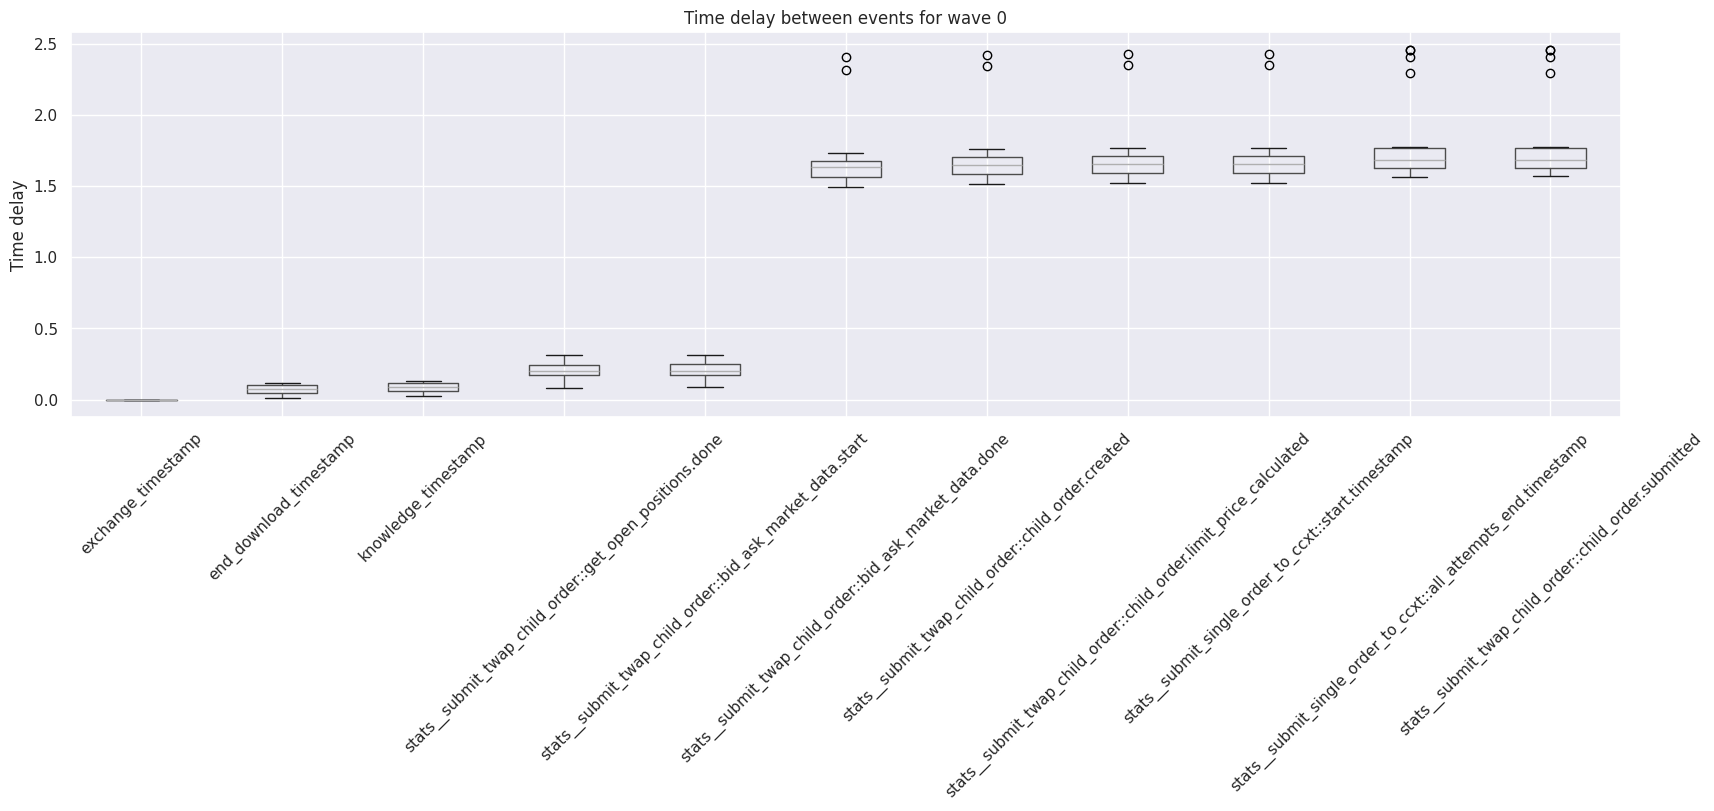

In [81]:
time_delays.boxplot(rot=45, ylabel="Time delay").set_title(
    "Time delay between events for wave 0"
)

### Plot the rest of the waves

In [82]:
# Plot non-zero wave time to get the "average" time of the
# order submission, without computing portfolio and forecasts.
non_wave_zero_events = oms_child_order_df_unpacked[
    oms_child_order_df_unpacked["wave_id"] > 0
]
# Get the timestamps of events for each child order
non_wave_zero_events = obccexqu.get_oms_child_order_timestamps(
    non_wave_zero_events
)
non_wave_zero_events = non_wave_zero_events.sort_values(
    non_wave_zero_events.first_valid_index(), axis=1
)

In [83]:
non_wave_zero_events.head(3)

,exchange_timestamp,end_download_timestamp,knowledge_timestamp,stats__submit_twap_child_order::get_open_positions.done,stats__submit_twap_child_order::bid_ask_market_data.start,stats__submit_twap_child_order::bid_ask_market_data.done,stats__submit_twap_child_order::child_order.created,stats__submit_twap_child_order::child_order.limit_price_calculated,stats__submit_single_order_to_ccxt::start.timestamp,stats__submit_single_order_to_ccxt::all_attempts_end.timestamp,stats__submit_twap_child_order::child_order.submitted
order_id,,,,,,,,,,,
5,2024-03-12 22:12:09.710000+00:00,2024-03-12 22:12:09.762096+00:00,2024-03-12 22:12:09.770832+00:00,2024-03-12 22:12:09.970314+00:00,2024-03-12 22:12:09.971574+00:00,2024-03-12 22:12:11.387294+00:00,2024-03-12 22:12:11.412629+00:00,2024-03-12 22:12:11.419067+00:00,2024-03-12 22:12:11.420533+00:00,2024-03-12 22:12:11.473233+00:00,2024-03-12 22:12:11.473792+00:00
11,2024-03-12 22:16:09.685000+00:00,2024-03-12 22:16:09.714794+00:00,2024-03-12 22:16:09.724702+00:00,2024-03-12 22:16:09.920616+00:00,2024-03-12 22:16:09.922215+00:00,2024-03-12 22:16:11.536174+00:00,2024-03-12 22:16:11.561188+00:00,2024-03-12 22:16:11.568059+00:00,2024-03-12 22:16:11.569398+00:00,2024-03-12 22:16:11.618705+00:00,2024-03-12 22:16:11.619324+00:00
12,2024-03-12 22:16:19.708000+00:00,2024-03-12 22:16:19.800808+00:00,2024-03-12 22:16:19.809421+00:00,2024-03-12 22:16:19.900654+00:00,2024-03-12 22:16:19.902329+00:00,2024-03-12 22:16:21.323745+00:00,2024-03-12 22:16:21.337968+00:00,2024-03-12 22:16:21.345061+00:00,2024-03-12 22:16:21.346383+00:00,2024-03-12 22:16:21.359722+00:00,2024-03-12 22:16:21.360266+00:00


In [84]:
# Get the difference between event timestamps.
time_delays = obccexqu.get_time_delay_between_events(non_wave_zero_events)

Text(0.5, 1.0, 'Time delay between events for waves >0')

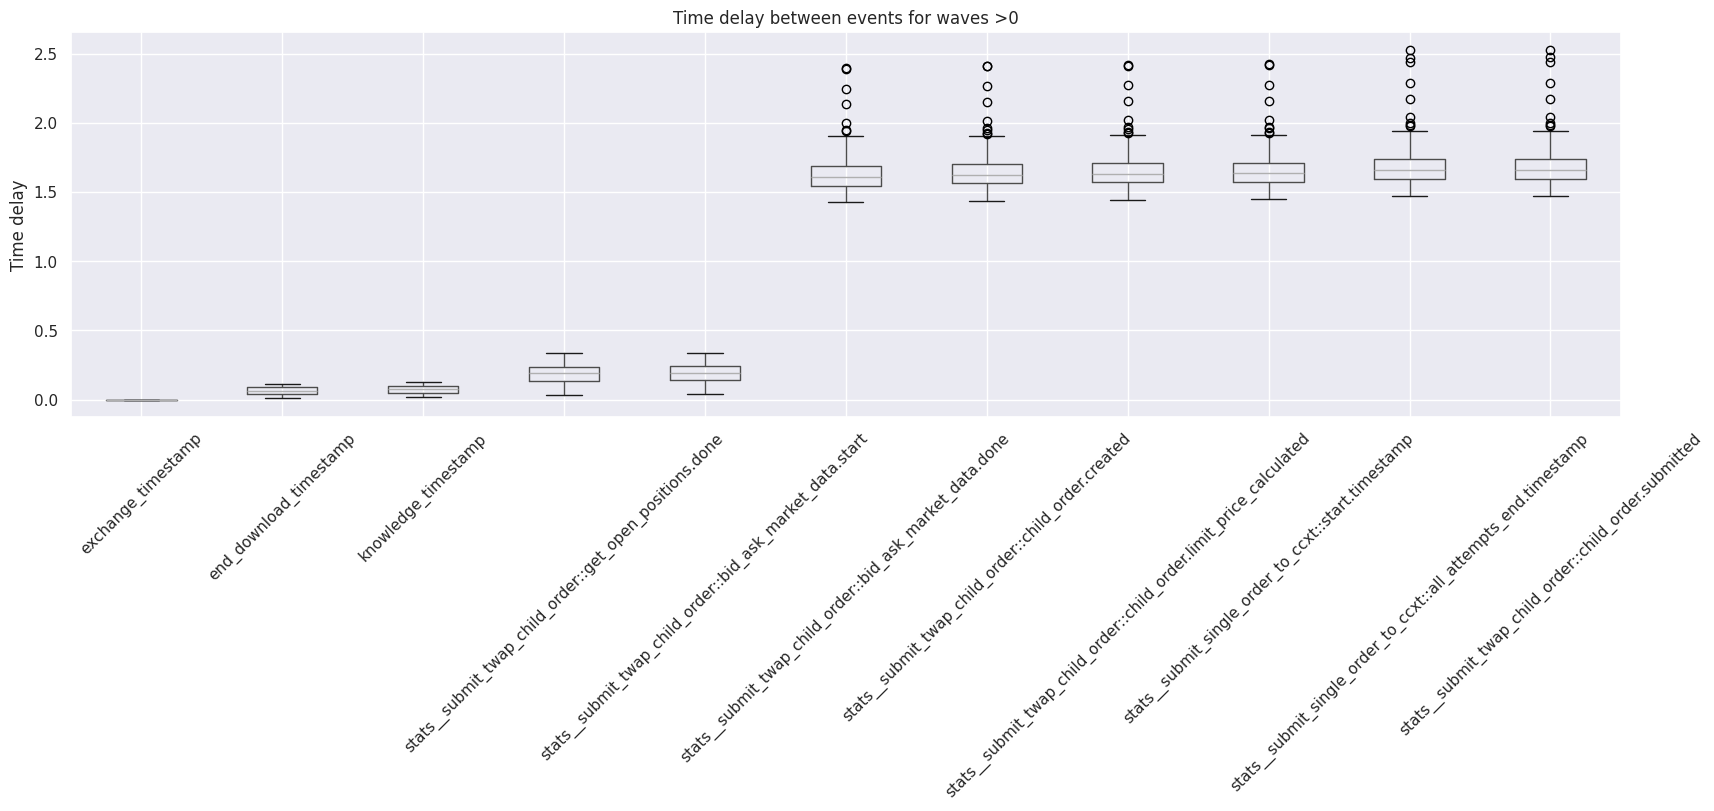

In [85]:
time_delays.boxplot(rot=45, ylabel="Time delay").set_title(
    "Time delay between events for waves >0"
)